In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import autograd

from IPython.display import clear_output
from PIL import Image

from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from collections import OrderedDict

### Load data

In [2]:
big_img = np.asarray(Image.open('train.jpg'))/255.0

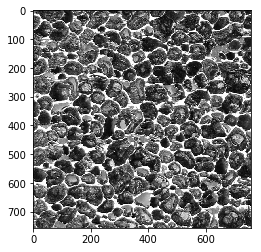

In [3]:
plt.imshow(big_img)

In [4]:
size = big_img.shape[:2]
#big_img = big_img[:size,:size]

In [5]:
np.mean(big_img.reshape(-1, size[0]*size[1]), axis=1)

array([0.38151564, 0.40965013, 0.40418628])

In [6]:
np.std(big_img.reshape(-1, size[0]*size[1]), axis=1)

array([0.26562867, 0.27503869, 0.27444678])

In [9]:
use_cuda = True
batch_size = 64

transform = transforms.ToTensor()
big_input = transform(big_img)

#big_input.permute()
#big_input = torch.from_numpy(big_img[None,:,:])
big_repeated = big_input[None,:,:,:].repeat(batch_size, 1, 1, 1)


if use_cuda:
    big_repeated = big_repeated.cuda()

In [8]:
#generator_inputs = torch.from_numpy(small_imgs[:,None,:,:])
def generate_noise(size):
    return torch.randn(size)

In [11]:
def calculate_gradient_penalty(netD, real_data, fake_data):
    alpha = torch.rand(real_data.shape[0], 1,1,1)
    alpha = alpha.expand(real_data.size())
    alpha = alpha.cuda() if use_cuda else alpha

    interpolates = alpha * real_data.data + ((1 - alpha) * fake_data.data)

    if use_cuda:
        interpolates = interpolates.cuda()
    interpolates = autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).cuda() if use_cuda else torch.ones(
                                  disc_interpolates.size()),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [10]:
noise_DIM = 20
small_width, small_height = 64, 64

conv_num = 256

img_DIM = big_img.shape[-1]

k_size = (5,5)

In [12]:
def build_grid(source_size,target_size):
    k = float(target_size)/float(source_size)
    direct = torch.linspace(0,k,target_size).unsqueeze(0).repeat(target_size,1).unsqueeze(-1)
    full = torch.cat([direct,direct.transpose(1,0)],dim=2).unsqueeze(0)
    return full.cuda()

def random_crop_grid(x,grid):
    delta = x.size(2)-grid.size(1)
    grid = grid.repeat(x.size(0),1,1,1).cuda()
    #Add random shifts by x
    grid[:,:,:,0] = grid[:,:,:,0]+ torch.FloatTensor(x.size(0)).cuda().random_(0, delta).unsqueeze(-1).unsqueeze(-1).expand(-1, grid.size(1), grid.size(2)) /x.size(2)
    #Add random shifts by y
    grid[:,:,:,1] = grid[:,:,:,1]+ torch.FloatTensor(x.size(0)).cuda().random_(0, delta).unsqueeze(-1).unsqueeze(-1).expand(-1, grid.size(1), grid.size(2)) /x.size(2)
    return grid

In [12]:
grid_source = build_grid(big_repeated.size(2), small_height)
#Make radom shift for each batch
grid_shifted = random_crop_grid(big_repeated,grid_source)
#Sample using grid sample
sampled_batch = F.grid_sample(big_repeated, grid_shifted.double())

NameError: name 'big_repeated' is not defined

In [1]:
def generate_batch(big_input, batch_size, small_width, small_height):
    output = torch.zeros((batch_size, img_DIM, small_width, small_height))
    indices = np.random.randint(0, big_input.shape[1] - small_height, size = (batch_size, 2))
    for i in range(batch_size):
        x, y = indices[i]
        output[i] = big_input[:,x:x+small_height, y:y+small_width]
    return output

In [14]:
discr_input = generate_batch(big_input, batch_size, small_width, small_height)

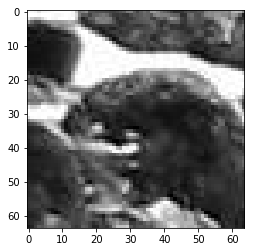

In [15]:
plt.imshow(discr_input[0].data.cpu().permute(1,2,0).numpy().squeeze())

# WGAN-GP

In [16]:
g_conv_pad = 1
g_tconv_pad = 1
d_conv_pad = 1

In [51]:
# skip this model

class Generator(torch.nn.Module):
    def __init__(self, noise_DIM):
        super().__init__()
        self.conv1 = nn.Conv2d(noise_DIM, conv_num, kernel_size=k_size, stride=2, padding=g_conv_pad)
        nn.init.xavier_normal_(self.conv1.weight)
        self.conv2 = nn.Conv2d(conv_num, conv_num//2, kernel_size=k_size, stride=2, padding=g_conv_pad)
        nn.init.xavier_normal_(self.conv2.weight)
        self.conv3 = nn.Conv2d(conv_num//2, conv_num//4, kernel_size=k_size, stride=2, padding=g_conv_pad)
        nn.init.xavier_normal_(self.conv3.weight)
        self.conv4 = nn.Conv2d(conv_num//4, conv_num//4, kernel_size=k_size, stride=2, padding=g_conv_pad)
        nn.init.xavier_normal_(self.conv4.weight)
        self.upsample1 = torch.nn.ConvTranspose2d(conv_num//4, conv_num//4, kernel_size=k_size, stride = 2, 
                                                  padding = g_tconv_pad)
        nn.init.xavier_normal_(self.upsample1.weight)
        self.upsample2 = torch.nn.ConvTranspose2d(conv_num//4, conv_num//2, kernel_size=k_size, stride = 2, 
                                                  padding = g_tconv_pad)
        nn.init.xavier_normal_(self.upsample2.weight)
        self.upsample3 = torch.nn.ConvTranspose2d(conv_num//2, conv_num, kernel_size=k_size, stride = 2, 
                                                  padding = g_tconv_pad)
        nn.init.xavier_normal_(self.upsample3.weight)
        self.upsample4 = torch.nn.ConvTranspose2d(conv_num, img_DIM, kernel_size=k_size, stride = 2, 
                                                  padding = g_tconv_pad)
        nn.init.xavier_normal_(self.upsample4.weight)
        #self.upsample4 = torch.nn.Upsample(3,1, kernel_size=(3,3), stride = 2, padding=1)

    def forward(self, x):
        #print(x.shape)
        x = self.conv1(x)
        x = F.leaky_relu(x)
        #x = self.bn1(x)
        x = F.instance_norm(x)
        #print(x.shape)
        
        x = self.conv2(x) 
        x = F.leaky_relu(x)
        x = F.instance_norm(x)

        x = self.conv3(x) 
        x = F.leaky_relu(x)
        x = F.instance_norm(x)

        x = self.conv4(x) 
        x = F.leaky_relu(x)
        x = F.instance_norm(x)
        
        #print(x.shape)

    
        x = self.upsample1(x)
        x = F.leaky_relu(x)
        x = F.instance_norm(x)
        x = self.upsample2(x)
        x = F.leaky_relu(x)
        x = F.instance_norm(x)
        x = self.upsample3(x)
        x = F.leaky_relu(x)
        x = F.instance_norm(x)
        x = self.upsample4(x)
        x = F.leaky_relu(x)
        x = F.instance_norm(x)
        #print(x.shape)
        #x = self.upsample4(x)
        #x = F.instance_norm(x)
        #print(x.shape)
        #print(x.shape)
        #points = np.random.randint(0, x.shape[2]-small_height, (x.shape[0],2))
        #if use_cuda: 
        #    mask1 = torch.zeros(x.shape[0],x.shape[1],small_height,small_height,requires_grad=True).cuda()
            # mask2 = torch.zeros(x.shape).cuda()
        #else:
        #    mask1 = torch.zeros(x.shape, requires_grad=True)
            # mask2 = torch.zeros(x.shape)
        #for i,point in enumerate(points):
        #    mask1[i,:] = x[i,:,point[0]:point[0]+64,point[0]:point[0]+64]
            # mask1[i,:] = torch.from_numpy(np.concatenate([np.eye(point[0], x.shape[2], k = point[0]), \
            #                                              np.eye(x.shape[2]-point[0], x.shape[2])])[None,:,:])
            # mask2[i,:] = torch.from_numpy(np.concatenate([np.eye(x.shape[2]-point[1], x.shape[2], k = point[1]).T, \
            #                                              np.eye(point[1], x.shape[2]).T],axis = 1))
        #new_x = mask1@x@mask2

        return x #new_x

In [59]:
class Discriminator(torch.nn.Module):    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(img_DIM, conv_num//4, kernel_size=k_size, stride = 2, padding=d_conv_pad)
        nn.init.xavier_normal_(self.conv1.weight)
        self.bn1 = nn.BatchNorm2d(conv_num//4)
        self.conv2 = nn.Conv2d(conv_num//4, conv_num//2, kernel_size=k_size, stride = 2, padding=d_conv_pad)
        nn.init.xavier_normal_(self.conv2.weight)
        self.bn2 = nn.BatchNorm2d(conv_num//2)
        self.conv3 = nn.Conv2d(conv_num//2, conv_num, kernel_size=k_size, stride = 2,padding=d_conv_pad)
        nn.init.xavier_normal_(self.conv2.weight)
        self.conv4 = nn.Conv2d(conv_num, 1, kernel_size=k_size, stride = 2,padding=d_conv_pad)
        nn.init.xavier_normal_(self.conv2.weight)
        self.bn3 = nn.BatchNorm2d(conv_num)
        self.bn4 = nn.BatchNorm2d(1)
        self.fc1 = nn.Linear(49, 1)
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = F.leaky_relu(x)
        x = self.bn1(x)        
        x = self.conv2(x)
        x = F.leaky_relu(x)
        x = self.bn2(x)
        x = self.conv3(x)
        x = F.leaky_relu(x)
        x = self.bn3(x)
        x = self.conv4(x)
        x = F.leaky_relu(x)
        x = self.bn4(x)
        x = x.view(x.shape[0],-1)
        #print(x.shape)
        x = self.fc1(x)
        x = torch.tanh(x)
        return x

In [1]:
generator = Generator(noise_DIM = noise_DIM)
discriminator = Discriminator()

if use_cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
LAMBDA = 1e-2
num_epochs = 800
iterations_per_epoch = 1


reg_coef = 1e-4
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=5e-4, betas=(0.5, 0.999), weight_decay=reg_coef)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=5e-4, betas=(0.5, 0.999), weight_decay=reg_coef)

k_d, k_g = 1, 4
C = 0.01
generator.train()
discriminator.train()

one = torch.ones([1])
mone = -1*one

if use_cuda:
    one = one.cuda()
    mone = mone.cuda()

noise_shape = (batch_size, noise_DIM, small_width-1, small_height-1)

grid_source = build_grid(big_repeated.size(2), small_height-1)

d_losses = []
g_losses = []
r_losses = []
f_losses = []
#fig = plt.figure(figsize = (10,10))
#plt.ion()
for epoch in range(num_epochs):
    d_loss = []
    g_loss = []
    r_loss = []
    f_loss = []
    for it in range(iterations_per_epoch):
    
        # Optimize D
        discriminator.train()
        #generator.eval()
        grid_shifted = random_crop_grid(big_repeated,grid_source)
        #Sample using grid sample
        discr_input = F.grid_sample(big_repeated, grid_shifted.double())
                
        if use_cuda:
            discr_input = discr_input.cuda()
        
        #print(type(discr_input))
        for i in range(k_d):
        
            d_optimizer.zero_grad()
            data_discr = discriminator(discr_input.float())
            real_loss = data_discr.mean()
            #real_loss.backward()
            
            # fake data
            noise = Variable(generate_noise(noise_shape).float())
            if use_cuda:
                noise = noise.cuda()
                
            data_gen = generator(noise)
            #print(data_gen.shape)
            data_gen_discr = discriminator(data_gen.float())
            fake_loss = data_gen_discr.mean()
            
            grad_penalty = calculate_gradient_penalty(discriminator, discr_input.float(), data_gen)*LAMBDA

            # total loss
            loss = - real_loss + fake_loss + grad_penalty*LAMBDA
            loss.backward(retain_graph=True)
            d_optimizer.step()
            
            for p in discriminator.parameters():
                p.data.clamp_(-C, C)
                    
            if use_cuda:
                f_loss.append(fake_loss.cpu().data.numpy().squeeze())
                r_loss.append(real_loss.cpu().data.numpy().squeeze())
                d_loss.append(loss.cpu().data.numpy().squeeze())
            else:
                f_loss.append(fake_loss.data.numpy().squeeze())
                r_loss.append(real_loss.data.numpy().squeeze())
                d_loss.append(loss.cpu().data.numpy().squeeze())
            
        # Optimize G

        discriminator.eval()
        #generator.train()
        for i in range(k_g):
            #noise = generate_noise(noise_shape).float()
            #if use_cuda:
            #    noise = noise.cuda()
            data_gen = generator(noise)
            loss = - discriminator(data_gen).mean()
            g_optimizer.zero_grad()
            loss.backward()
            g_optimizer.step()
            if use_cuda:
                g_loss.append(loss.cpu().data.numpy().squeeze())
            else:
                g_loss.append(loss.data.numpy().squeeze())
     
    clear_output(wait=True)
    #print('Epoch #{}, D loss {}'.format(epoch+1, loss.cpu().data.numpy().squeeze()))
    print('Epoch #{}, D loss {}'.format(epoch+1, sum(d_loss)/len(d_loss)))
    print('Epoch #{}, G loss {}'.format(epoch+1, sum(g_loss)/len(g_loss)))
    
    d_losses.append(sum(d_loss)/len(d_loss))
    g_losses.append(sum(g_loss)/len(g_loss))
    f_losses.append(sum(f_loss)/len(f_loss))
    r_losses.append(sum(r_loss)/len(r_loss))
    
    #fig.clf()
    #ax = plt.gca()
    plt.figure(figsize=(15,7))
    plt.subplot(121)
    plt.plot(r_losses, label = 'discriminator real loss')
    plt.plot(f_losses, label = 'discriminator fake loss')
    plt.plot(g_losses, label = 'generator loss')

    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    plt.subplot(122)
    res = data_gen[0].data.cpu().permute(1,2,0).numpy().squeeze()
    plt.imshow(np.clip(res, 0, 1))
    #plt.draw()
    plt.show()

    #plt.pause(0.0001)

NameError: name 'Generator' is not defined

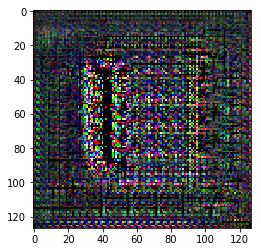

In [64]:
res = data_gen[0].data.cpu().permute(1,2,0).numpy().squeeze()
plt.imshow(np.clip(res, 0, 1))

# Model from SGANs for texture synthesis

In [18]:
noise_DIM = 20
#small_width, small_height = 128, 128

conv_num = 256

img_DIM = big_img.shape[-1]

k_size = (5,5)

class Generator(torch.nn.Module):
    
    def __init__(self, noise_DIM):
        super().__init__()
        
        self.upsample1 = torch.nn.ConvTranspose2d(noise_DIM, conv_num, kernel_size=k_size, stride = 2, 
                                                  padding = 1) #, output_padding=1)
        nn.init.normal_(self.upsample1.weight, std=0.02)
        self.bn1 = nn.BatchNorm2d(conv_num)


        self.upsample2 = torch.nn.ConvTranspose2d(conv_num, conv_num//2, kernel_size=k_size, stride = 2, 
                                                  padding = 1) #2, output_padding=1)
        nn.init.normal_(self.upsample2.weight, std=0.02)
        self.bn2 = nn.BatchNorm2d(conv_num//2)


        self.upsample3 = torch.nn.ConvTranspose2d(conv_num//2, conv_num//4, kernel_size=k_size, stride = 2,
                                                  padding = 1) #2 output_padding=1)
        nn.init.normal_(self.upsample3.weight, std=0.02)
        self.bn3 = nn.BatchNorm2d(conv_num//4)
        self.upsample4 = torch.nn.ConvTranspose2d(conv_num//4, img_DIM, kernel_size=k_size, stride = 2, 
                                                  padding = 1) #2, output_padding=1)
        nn.init.normal_(self.upsample4.weight, std=0.02)

    def forward(self, x):
        #print(x.shape)
        x = self.upsample1(x)
        #print(x.shape)
        x = F.relu(x)
        x = self.bn1(x)
        #x = F.instance_norm(x)
        x = self.upsample2(x)
        x = F.relu(x)
        x = self.bn2(x)
        #x = F.instance_norm(x)
        x = self.upsample3(x)
        x = F.relu(x)
        #x = F.instance_norm(x)
        x = self.bn3(x)
        x = self.upsample4(x)
        #x = F.relu(x)
        #x = self.bn4(x)
        #print(x.shape)
        #print(x.shape)
        return x #new_x

In [19]:
class Discriminator(torch.nn.Module):    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(img_DIM, conv_num//4, kernel_size=k_size, stride = 2, padding=1)
        nn.init.normal_(self.conv1.weight, std=0.02)
        self.bn1 = nn.BatchNorm2d(conv_num//4)
        self.conv2 = nn.Conv2d(conv_num//4, conv_num//2, kernel_size=k_size, stride = 2, padding=1)
        nn.init.normal_(self.conv2.weight, std=0.02)
        self.bn2 = nn.BatchNorm2d(conv_num//2)
        self.conv3 = nn.Conv2d(conv_num//2, conv_num, kernel_size=k_size, stride = 2, padding=1)
        nn.init.normal_(self.conv3.weight, std=0.02)
        self.bn3 = nn.BatchNorm2d(conv_num)
        self.conv4 = nn.Conv2d(conv_num, 1, kernel_size=k_size, stride = 2, padding=1)
        nn.init.normal_(self.conv4.weight, std=0.02)
        self.bn4 = nn.BatchNorm2d(1)
        self.fc1 = nn.Linear(49, 1)
        nn.init.normal_(self.fc1.weight, std = 0.02)
        nn.init.constant_(self.fc1.bias, 0)
        self.last_layer = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = F.leaky_relu(x)
        #x = self.bn1(x)        
        x = self.conv2(x)
        x = F.leaky_relu(x)
        x = self.bn2(x)
        x = self.conv3(x)
        x = F.leaky_relu(x)
        x = self.bn3(x)
        x = self.conv4(x)
        x = F.leaky_relu(x)
        x = self.bn4(x)
        x = x.view(x.shape[0],-1)
        #print(x.shape)
        #print(x.shape)
        x = self.fc1(x)
        #x = F.leaky_relu(x)
        x = self.last_layer(x)
        return x
    

In [20]:
def generate_noise(size):
    return -1+2*torch.rand(size)

In [21]:
noise_DIM = 20
#small_width, small_height = 128, 128

conv_num = 256

img_DIM = big_img.shape[-1]

k_size = (5,5)

class Generator(torch.nn.Module):
    
    def __init__(self, noise_DIM):
        super().__init__()
        
        self.upsample1 = torch.nn.ConvTranspose2d(noise_DIM, conv_num, kernel_size=k_size, stride = 2, 
                                                  padding = 1) #, output_padding=1)
        nn.init.normal_(self.upsample1.weight, std=0.02)
        self.bn1 = nn.BatchNorm2d(conv_num)


        self.upsample2 = torch.nn.ConvTranspose2d(conv_num, conv_num//2, kernel_size=k_size, stride = 2, 
                                                  padding = 1) #2, output_padding=1)
        nn.init.normal_(self.upsample2.weight, std=0.02)
        self.bn2 = nn.BatchNorm2d(conv_num//2)


        self.upsample3 = torch.nn.ConvTranspose2d(conv_num//2, conv_num//4, kernel_size=k_size, stride = 2,
                                                  padding = 1) #2 output_padding=1)
        nn.init.normal_(self.upsample3.weight, std=0.02)
        self.bn3 = nn.BatchNorm2d(conv_num//4)
        self.upsample4 = torch.nn.ConvTranspose2d(conv_num//4, img_DIM, kernel_size=k_size, stride = 2, 
                                                  padding = 1) #2, output_padding=1)
        nn.init.normal_(self.upsample4.weight, std=0.02)
        
        #self.net = nn.Sequential(self.upsample1, self.bn1, nn.ReLU())

    def forward(self, x):
        #print(x.shape)
        x = self.upsample1(x)
        #print(x.shape)
        x = F.relu(x)
        x = self.bn1(x)
        #x = F.instance_norm(x)
        x = self.upsample2(x)
        x = F.relu(x)
        x = self.bn2(x)
        #x = F.instance_norm(x)
        x = self.upsample3(x)
        x = F.relu(x)
        #x = F.instance_norm(x)
        x = self.bn3(x)
        x = self.upsample4(x)
        #x = F.relu(x)
        #x = self.bn4(x)
        #print(x.shape)
        #print(x.shape)
        return x #new_x

In [22]:
class Discriminator(torch.nn.Module):    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(img_DIM, conv_num//4, kernel_size=k_size, stride = 2, padding=1)
        nn.init.normal_(self.conv1.weight, std=0.02)
        self.bn1 = nn.BatchNorm2d(conv_num//4)
        self.conv2 = nn.Conv2d(conv_num//4, conv_num//2, kernel_size=k_size, stride = 2, padding=1)
        nn.init.normal_(self.conv2.weight, std=0.02)
        self.bn2 = nn.BatchNorm2d(conv_num//2)
        self.conv3 = nn.Conv2d(conv_num//2, conv_num, kernel_size=k_size, stride = 2, padding=1)
        nn.init.normal_(self.conv3.weight, std=0.02)
        self.bn3 = nn.BatchNorm2d(conv_num)
        self.conv4 = nn.Conv2d(conv_num, 1, kernel_size=k_size, stride = 2, padding=1)
        nn.init.normal_(self.conv4.weight, std=0.02)
        self.bn4 = nn.BatchNorm2d(1)
        self.fc1 = nn.Linear(49, 1)
        nn.init.normal_(self.fc1.weight, std = 0.02)
        nn.init.constant_(self.fc1.bias, 0)
        self.last_layer = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = F.leaky_relu(x)
        #x = self.bn1(x)        
        x = self.conv2(x)
        x = F.leaky_relu(x)
        x = self.bn2(x)
        x = self.conv3(x)
        x = F.leaky_relu(x)
        x = self.bn3(x)
        x = self.conv4(x)
        x = F.leaky_relu(x)
        x = self.bn4(x)
        x = x.view(x.shape[0],-1)
        #print(x.shape)
        #print(x.shape)
        x = self.fc1(x)
        #x = F.leaky_relu(x)
        x = self.last_layer(x)
        return x
    

Epoch #1, D loss 0.7003175616264343
Epoch #1, G loss 0.6881003975868225


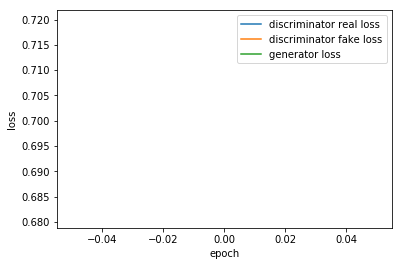

In [ ]:
# batch_size = 64, size = 128x128

generator = Generator(noise_DIM = noise_DIM)
discriminator = Discriminator()

if use_cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()

num_epochs = 1000
iterations_per_epoch = 1


reg_coef = 1e-5
d_optimizer = torch.optim.Adam(discriminator.parameters(),  lr=0.0005, betas=(0.5, 0.999), weight_decay=reg_coef)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0005, betas=(0.5, 0.999), weight_decay=reg_coef)
k_d, k_g = 1, 1
#C = 0.01
LAMBDA = 0.2
generator.train()
discriminator.train()

one = torch.ones([1])
mone = -1*one

if use_cuda:
    one = one.cuda()
    mone = mone.cuda()

noise_shape = (batch_size, noise_DIM, small_width//16-1, small_height//16-1)

grid_source = build_grid(big_repeated.size(2), small_height-1)

d_losses = []
g_losses = []
r_losses = []
f_losses = []

# adversarial_loss = torch.nn.BCELoss()

valid = Variable(torch.Tensor(batch_size, 1).fill_(1.0), requires_grad=False)
fake = Variable(torch.Tensor(batch_size, 1).fill_(0.0), requires_grad=False)
discr_input = 
if use_cuda:
    valid = valid.cuda()
    fake = fake.cuda()
#fig = plt.figure(figsize = (10,10))
#plt.ion()
for epoch in range(num_epochs):
    d_loss = []
    g_loss = []
    r_loss = []
    f_loss = []
    for it in range(iterations_per_epoch):
    
        
        #discriminator.train()
        #grid_shifted = random_crop_grid(big_repeated,grid_source)
        #Sample using grid sample
        #discr_input = F.grid_sample(big_repeated, grid_shifted.double())       
        if use_cuda:
            discr_input = discr_input.cuda()
        
        
        # Optimize G

        for i in range(k_g):
            noise = generate_noise(noise_shape).float()
            if use_cuda:
                noise = noise.cuda()
            data_gen = generator(noise)
            
            loss = F.binary_cross_entropy(discriminator(data_gen), valid)
            #loss = - discriminator(data_gen).mean()
            
            
            g_optimizer.zero_grad()
            
            loss.backward(retain_graph=True)
            
            g_optimizer.step()
            
            if use_cuda:
                g_loss.append(loss.cpu().data.numpy().squeeze())
            else:
                g_loss.append(loss.data.numpy().squeeze())
        
        
        # Optimize D

        for i in range(k_d):
        
            d_optimizer.zero_grad()
            data_discr = discriminator(discr_input.float())
            
            real_loss =  F.binary_cross_entropy(data_discr, valid)
            
            # fake data
            noise = Variable(generate_noise(noise_shape).float())
            if use_cuda:
                noise = noise.cuda()
                
            data_gen = generator(noise)
            
            fake_loss = F.binary_cross_entropy(discriminator(data_gen), fake)
            
            loss = (real_loss + fake_loss) / 2
 
            loss.backward(retain_graph=True)
            d_optimizer.step()

                    
            if use_cuda:
                f_loss.append(fake_loss.cpu().data.numpy().squeeze())
                r_loss.append(real_loss.cpu().data.numpy().squeeze())
                d_loss.append(loss.cpu().data.numpy().squeeze())
            else:
                f_loss.append(fake_loss.data.numpy().squeeze())
                r_loss.append(real_loss.data.numpy().squeeze())
                d_loss.append(loss.cpu().data.numpy().squeeze())

     
    clear_output(wait=True)
    #print(fake_loss - loss)
    print('Epoch #{}, D loss {}'.format(epoch+1, sum(d_loss)/len(d_loss)))
    print('Epoch #{}, G loss {}'.format(epoch+1, sum(g_loss)/len(g_loss)))
    
    d_losses.append(sum(d_loss)/len(d_loss))
    g_losses.append(sum(g_loss)/len(g_loss))
    f_losses.append(sum(f_loss)/len(f_loss))
    r_losses.append(sum(r_loss)/len(r_loss))
    
    #fig.clf()
    #ax = plt.gca()
    plt.plot(r_losses, label = 'discriminator real loss')
    plt.plot(f_losses, label = 'discriminator fake loss')
    plt.plot(g_losses, label = 'generator loss')

    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    #plt.draw()
    plt.show()
    #plt.pause(0.0001)

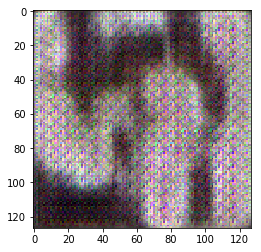

In [35]:
res = data_gen[0].data.cpu().permute(1,2,0).numpy().squeeze()
plt.imshow(np.clip(res, 0, 1))

Epoch #1000, D loss 0.3727898597717285
Epoch #1000, G loss 2.672135909398397


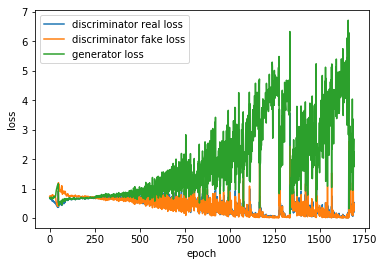

In [22]:
for epoch in range(1000):
    d_loss = []
    g_loss = []
    r_loss = []
    f_loss = []
    for it in range(iterations_per_epoch):
    
        
        #discriminator.train()
        grid_shifted = random_crop_grid(big_repeated,grid_source)
        #Sample using grid sample
        discr_input = F.grid_sample(big_repeated, grid_shifted.double())
                
        if use_cuda:
            discr_input = discr_input.cuda()
        
        
        # Optimize G

        for i in range(k_g):
            noise = generate_noise(noise_shape).float()
            if use_cuda:
                noise = noise.cuda()
            data_gen = generator(noise)
            
            loss = F.binary_cross_entropy(discriminator(data_gen), valid)
            #loss = - discriminator(data_gen).mean()
            
            
            g_optimizer.zero_grad()
            
            loss.backward(retain_graph=True)
            
            g_optimizer.step()
            
            if use_cuda:
                g_loss.append(loss.cpu().data.numpy().squeeze())
            else:
                g_loss.append(loss.data.numpy().squeeze())
        
        
        # Optimize D

        for i in range(k_d):
        
            d_optimizer.zero_grad()
            data_discr = discriminator(discr_input.float())
            
            real_loss =  F.binary_cross_entropy(data_discr, valid)
            
            # fake data
            noise = Variable(generate_noise(noise_shape).float())
            if use_cuda:
                noise = noise.cuda()
                
            data_gen = generator(noise)
            
            fake_loss = F.binary_cross_entropy(discriminator(data_gen), fake)
            
            loss = (real_loss + fake_loss) / 2
 
            loss.backward(retain_graph=True)
            d_optimizer.step()

                    
            if use_cuda:
                f_loss.append(fake_loss.cpu().data.numpy().squeeze())
                r_loss.append(real_loss.cpu().data.numpy().squeeze())
                d_loss.append(loss.cpu().data.numpy().squeeze())
            else:
                f_loss.append(fake_loss.data.numpy().squeeze())
                r_loss.append(real_loss.data.numpy().squeeze())
                d_loss.append(loss.cpu().data.numpy().squeeze())

     
    clear_output(wait=True)
    #print(fake_loss - loss)
    print('Epoch #{}, D loss {}'.format(epoch+1, sum(d_loss)/len(d_loss)))
    print('Epoch #{}, G loss {}'.format(epoch+1, sum(g_loss)/len(g_loss)))
    
    d_losses.append(sum(d_loss)/len(d_loss))
    g_losses.append(sum(g_loss)/len(g_loss))
    f_losses.append(sum(f_loss)/len(f_loss))
    r_losses.append(sum(r_loss)/len(r_loss))
    
    #fig.clf()
    #ax = plt.gca()
    plt.plot(r_losses, label = 'discriminator real loss')
    plt.plot(f_losses, label = 'discriminator fake loss')
    plt.plot(g_losses, label = 'generator loss')

    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    #plt.draw()
    plt.show()
    #plt.pause(0.0001)

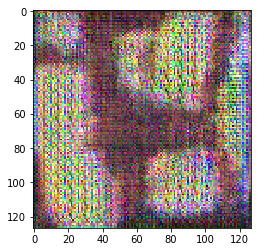

In [23]:
res = data_gen[0].data.cpu().permute(1,2,0).numpy().squeeze()
plt.imshow(np.clip(res, 0, 1))

In [24]:
generator = Generator(noise_DIM = noise_DIM)
discriminator = Discriminator()

if use_cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()

num_epochs = 1500
iterations_per_epoch = 1


reg_coef = 1e-5
d_optimizer = torch.optim.Adam(discriminator.parameters(),  lr=0.0005, betas=(0.5, 0.999), weight_decay=reg_coef)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0005, betas=(0.5, 0.999), weight_decay=reg_coef)
k_d, k_g = 1, 3
#C = 0.01
LAMBDA = 0.1
generator.train()
discriminator.train()

one = torch.ones([1])
mone = -1*one

if use_cuda:
    one = one.cuda()
    mone = mone.cuda()

noise_shape = (batch_size, noise_DIM, small_width//2**(n+2)-1, small_height//2**(n+2)-1)

grid_source = build_grid(big_repeated.size(2), small_height-1)

d_losses = []
g_losses = []
r_losses = []
f_losses = []

# adversarial_loss = torch.nn.BCELoss()

valid = Variable(torch.Tensor(batch_size, 1).fill_(1.0), requires_grad=False)
fake = Variable(torch.Tensor(batch_size, 1).fill_(0.0), requires_grad=False)

if use_cuda:
    valid = valid.cuda()
    fake = fake.cuda()
#fig = plt.figure(figsize = (10,10))
#plt.ion()
for epoch in range(num_epochs):
    d_loss = []
    g_loss = []
    r_loss = []
    f_loss = []
    for it in range(iterations_per_epoch):
    
        
        #discriminator.train()
        grid_shifted = random_crop_grid(big_repeated,grid_source)
        #Sample using grid sample
        discr_input = F.grid_sample(big_repeated, grid_shifted.double())
                
        if use_cuda:
            discr_input = discr_input.cuda()
        
        
        # Optimize G

        for i in range(k_g):
            noise = generate_noise(noise_shape).float()
            if use_cuda:
                noise = noise.cuda()
            data_gen = generator(noise)
            
            loss = F.binary_cross_entropy(discriminator(data_gen), valid)
            #loss = - discriminator(data_gen).mean()
            
            
            g_optimizer.zero_grad()
            
            loss.backward(retain_graph=True)
            
            g_optimizer.step()
            
            if use_cuda:
                g_loss.append(loss.cpu().data.numpy().squeeze())
            else:
                g_loss.append(loss.data.numpy().squeeze())
        
        
        # Optimize D

        for i in range(k_d):
        
            d_optimizer.zero_grad()
            data_discr = discriminator(discr_input.float())
            
            real_loss =  F.binary_cross_entropy(data_discr, valid)
            
            # fake data
            noise = Variable(generate_noise(noise_shape).float())
            if use_cuda:
                noise = noise.cuda()
                
            data_gen = generator(noise)
            
            fake_loss = F.binary_cross_entropy(discriminator(data_gen), fake)
            
            loss = (real_loss + fake_loss) / 2
 
            loss.backward(retain_graph=True)
            d_optimizer.step()

                    
            if use_cuda:
                f_loss.append(fake_loss.cpu().data.numpy().squeeze())
                r_loss.append(real_loss.cpu().data.numpy().squeeze())
                d_loss.append(loss.cpu().data.numpy().squeeze())
            else:
                f_loss.append(fake_loss.data.numpy().squeeze())
                r_loss.append(real_loss.data.numpy().squeeze())
                d_loss.append(loss.cpu().data.numpy().squeeze())

     
    clear_output(wait=True)
    #print(fake_loss - loss)
    print('Epoch #{}, D loss {}'.format(epoch+1, sum(d_loss)/len(d_loss)))
    print('Epoch #{}, G loss {}'.format(epoch+1, sum(g_loss)/len(g_loss)))
    
    d_losses.append(sum(d_loss)/len(d_loss))
    g_losses.append(sum(g_loss)/len(g_loss))
    f_losses.append(sum(f_loss)/len(f_loss))
    r_losses.append(sum(r_loss)/len(r_loss))
    
    #fig.clf()
    #ax = plt.gca()
    plt.figure(figsize=(15,7))


    plt.subplot(121)
    plt.plot(r_losses, label = 'discriminator real loss')
    plt.plot(f_losses, label = 'discriminator fake loss')
    plt.plot(g_losses, label = 'generator loss')

    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    plt.subplot(122)
    res = data_gen[0].data.cpu().permute(1,2,0).numpy().squeeze()
    plt.imshow(np.clip(res, 0, 1))
    #plt.draw()
    plt.show()
    #plt.pause(0.0001)

RuntimeError: cudaEventSynchronize in future::wait: device-side assert triggered

# continue here

In [23]:
noise_DIM = 20
small_width, small_height = 128, 128

conv_num = 256

img_DIM = big_img.shape[-1]

k_size = (5,5)

n = 2
tmp = small_height-1
for i in range(n+2):
    tmp = (tmp-1)//2
linear_input_size = tmp**2*noise_DIM

In [24]:
def generate_noise(size):
    return -1+2*torch.rand(size)

In [25]:
class Noise(nn.Module):
    def __init__(self, size):
        super(Noise, self).__init__()
        self.size = size
    def forward(self):
        if use_cuda:
            x = (-1+2*torch.rand(self.size)).cuda()
        else:
            x = -1+2*torch.rand(self.size)
        return x

In [26]:
def init_weights(m):
    if type(m) == nn.Conv2d:
        #nn.init.normal_(m.weight, std=0.02)
        nn.init.xavier_uniform(m.weight)
        #m.bias.data.fill_(0.01)
    elif type(m) == nn.Linear:
        nn.init.xavier_uniform(m.weight)
        #nn.init.normal_(m.weight, std=0.02)
        m.bias.data.fill_(0.01)

In [27]:
class Flatten(nn.Module):
    def forward(self,x):
        return x.view(x.shape[0], -1)

In [28]:
class Generator(torch.nn.Module):
    
    def __init__(self, noise_DIM):
        super().__init__()
        
        layers = OrderedDict()
        layers.update({'conv_t_0': nn.ConvTranspose2d(noise_DIM, conv_num, kernel_size=k_size, stride = 2, padding=1)})
        layers.update({'relu_0': nn.ReLU()})
        layers.update({'bn_0': nn.BatchNorm2d(conv_num)})

        for i in range(1,n+1):
            layers.update({'conv_t_'+str(i) : nn.ConvTranspose2d(conv_num//2**(i-1), conv_num//2**i, 
                                                                 kernel_size=k_size, stride = 2, padding=1)})
            layers.update({'relu_'+str(i): nn.ReLU()})
            layers.update({'bn_'+str(i): nn.BatchNorm2d(conv_num//2**i)})



        layers.update({'conv_t': nn.ConvTranspose2d(conv_num//2**n, img_DIM, kernel_size=k_size, stride = 2, padding=1)})
        self.net = nn.Sequential(layers)
        self.net.apply(init_weights)


    def forward(self, x):
        x = self.net(x)
        return x #new_x

In [29]:
# batch_size = 32, img_size = 64x64

class Discriminator(torch.nn.Module):    
    def __init__(self):
        super().__init__()
        layers = OrderedDict()
        layers.update({'conv_0': nn.Conv2d(img_DIM, conv_num//2**n, kernel_size=k_size, stride = 2, padding=1)})
        layers.update({'lrelu_0': nn.LeakyReLU()})

        for i in range(n-1,-1,-1):
            #print(nn.Conv2d(conv_num//2**(i+1), conv_num//2**i, kernel_size=k_size, stride = 2, padding=1))
            layers.update({'conv_'+str(n-1-i+1): nn.Conv2d(conv_num//2**(i+1), conv_num//2**i, 
                                                         kernel_size=k_size, stride = 2, padding=1)})
            layers.update({'lrelu_'+str(n-1-i+1): nn.LeakyReLU()})
            layers.update({'bn_'+str(n-1-i+1): nn.BatchNorm2d(conv_num//2**i)})


        layers.update({'conv': nn.Conv2d(conv_num, noise_DIM, kernel_size=k_size, stride = 2, padding=1)})
        layers.update({'flatten': Flatten()})
        layers.update({'fc': nn.Linear(linear_input_size, 1)})
        #layers.update({'tanh':nn.Tanh()})
        #print(layers)
        self.net = nn.Sequential(layers)
        self.net.apply(init_weights)

    def forward(self, x):
        x = self.net(x)
        return x
    

In [30]:
# batch_size = 32, img_size = 64x64

generator = Generator(noise_DIM = noise_DIM)
discriminator = Discriminator()

noise_shape = (batch_size, noise_DIM, small_width//2**(n+2)-1, small_height//2**(n+2)-1)

noise_gen = Noise(noise_shape)

if use_cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    noise_gen = noise_gen.cuda()
num_epochs = 700
iterations_per_epoch = 1

#discr_input = big_input[None,:, :small_height-1,:small_height-1].repeat(batch_size, 1, 1, 1)
#if use_cuda:
#    discr_input = discr_input.cuda()
    
    
reg_coef = 1e-5
d_optimizer = torch.optim.Adam(discriminator.parameters(),  lr=0.0005, betas=(0.5, 0.999), weight_decay=reg_coef) # lr=0.0005 for sampling
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0005, betas=(0.5, 0.999), weight_decay=reg_coef)
k_d, k_g = 1, 4  # 1, 4 - for sampling
#C = 0.01
#LAMBDA = 0.1
generator.train()
discriminator.train()

one = torch.ones([1])
mone = -1*one

if use_cuda:
    one = one.cuda()
    mone = mone.cuda()

grid_source = build_grid(big_repeated.size(2), small_height-1)

d_losses = []
g_losses = []
r_losses = []
f_losses = []

# adversarial_loss = torch.nn.BCELoss()

valid = Variable(torch.Tensor(batch_size, 1).fill_(1.0), requires_grad=False)
fake = Variable(torch.Tensor(batch_size, 1).fill_(0.0), requires_grad=False)

if use_cuda:
    valid = valid.cuda()
    fake = fake.cuda()
#fig = plt.figure(figsize = (10,10))
#plt.ion()
for epoch in range(num_epochs):
    d_loss = []
    g_loss = []
    r_loss = []
    f_loss = []
    for it in range(iterations_per_epoch):
    
        
        #discriminator.train()
        grid_shifted = random_crop_grid(big_repeated,grid_source)
        #Sample using grid sample
        discr_input = F.grid_sample(big_repeated, grid_shifted.double())
                
        if use_cuda:
            discr_input = discr_input.cuda()
        
        
        # Optimize G

        for i in range(k_g):
            #noise = generate_noise(noise_shape).float()
            #if use_cuda:
            #    noise = noise.cuda()
            
            noise = noise_gen()
            data_gen = generator(noise)
            print(data_gen.shape)
            loss = F.binary_cross_entropy_with_logits(discriminator(data_gen), valid)
            #loss = - discriminator(data_gen).mean()
            
            
            g_optimizer.zero_grad()
            
            loss.backward(retain_graph=True)
            
            g_optimizer.step()
            
            if use_cuda:
                g_loss.append(loss.cpu().data.numpy().squeeze())
            else:
                g_loss.append(loss.data.numpy().squeeze())
        
        
        # Optimize D

        for i in range(k_d):
        
            d_optimizer.zero_grad()
            data_discr = discriminator(discr_input.float())
            
            real_loss =  F.binary_cross_entropy_with_logits(data_discr, valid)
            
            # fake data
            noise = noise_gen()
            
            #noise = Variable(generate_noise(noise_shape).float())
            #if use_cuda:
            #    noise = noise.cuda()
                
            data_gen = generator(noise)
            
            fake_loss = F.binary_cross_entropy_with_logits(discriminator(data_gen), fake)
            
            loss = (real_loss + fake_loss) / 2
 
            loss.backward(retain_graph=True)
            d_optimizer.step()

                    
            if use_cuda:
                f_loss.append(fake_loss.cpu().data.numpy().squeeze())
                r_loss.append(real_loss.cpu().data.numpy().squeeze())
                d_loss.append(loss.cpu().data.numpy().squeeze())
            else:
                f_loss.append(fake_loss.data.numpy().squeeze())
                r_loss.append(real_loss.data.numpy().squeeze())
                d_loss.append(loss.cpu().data.numpy().squeeze())

     
    clear_output(wait=True)
    #print(fake_loss - loss)
    print('Epoch #{}, D loss {}'.format(epoch+1, sum(d_loss)/len(d_loss)))
    print('Epoch #{}, G loss {}'.format(epoch+1, sum(g_loss)/len(g_loss)))
    
    d_losses.append(sum(d_loss)/len(d_loss))
    g_losses.append(sum(g_loss)/len(g_loss))
    f_losses.append(sum(f_loss)/len(f_loss))
    r_losses.append(sum(r_loss)/len(r_loss))
    
    #fig.clf()
    #ax = plt.gca()
    plt.figure(figsize=(15,7))


    plt.subplot(121)
    plt.plot(r_losses, label = 'discriminator real loss')
    plt.plot(f_losses, label = 'discriminator fake loss')
    plt.plot(g_losses, label = 'generator loss')

    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    plt.subplot(122)
    res = data_gen[0].data.cpu().permute(1,2,0).numpy().squeeze()
    plt.imshow(np.clip(res, 0, 1))
    #plt.draw()
    plt.show()
    #plt.pause(0.0001)

Epoch #74, D loss 0.859635591506958
Epoch #74, G loss 1.0190854668617249


KeyboardInterrupt: 

In [31]:
noise = generate_noise((1, noise_DIM, 46, 46)).float()
if use_cuda:
    noise = noise.cuda()
data_gen = generator(noise)

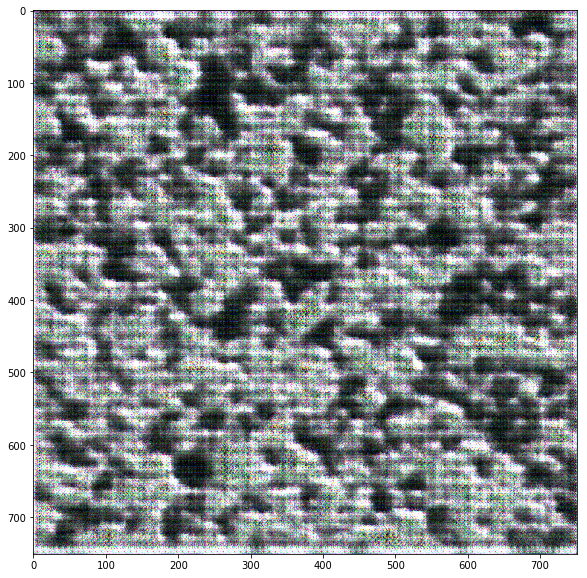

In [32]:
plt.figure(figsize=(10,10))
res = data_gen[0].data.cpu().permute(1,2,0).numpy().squeeze()
plt.imshow(np.clip(res, 0, 1))

In [43]:
res.shape

(751, 751, 3)

In [44]:
plt.imsave('gan_res_half.jpg', np.clip(res,0,1))

## WGAN

In [33]:
noise_DIM = 20
#small_width, small_height = 128, 128

conv_num = 256

img_DIM = big_img.shape[-1]

k_size = (5,5)

n = 2
tmp = small_height-1
for i in range(n+2):
    tmp = (tmp-1)//2
linear_input_size = tmp**2*noise_DIM

In [34]:
# batch_size = 32, img_size = 64x64

class Discriminator(torch.nn.Module):    
    def __init__(self):
        super().__init__()
        layers = OrderedDict()
        layers.update({'conv_0': nn.Conv2d(img_DIM, conv_num//2**n, kernel_size=k_size, stride = 2, padding=1)})
        layers.update({'lrelu_0': nn.LeakyReLU()})

        for i in range(n-1,-1,-1):
            #print(nn.Conv2d(conv_num//2**(i+1), conv_num//2**i, kernel_size=k_size, stride = 2, padding=1))
            layers.update({'conv_'+str(n-1-i+1): nn.Conv2d(conv_num//2**(i+1), conv_num//2**i, 
                                                         kernel_size=k_size, stride = 2, padding=1)})
            layers.update({'lrelu_'+str(n-1-i+1): nn.LeakyReLU()})
            layers.update({'bn_'+str(n-1-i+1): nn.BatchNorm2d(conv_num//2**i)})


        layers.update({'conv': nn.Conv2d(conv_num, noise_DIM, kernel_size=k_size, stride = 2, padding=1)})
        layers.update({'flatten': Flatten()})
        layers.update({'fc': nn.Linear(linear_input_size, 1)})
        layers.update({'tahn': nn.Tanh()})
        #layers.update({'tanh':nn.Tanh()})
        #print(layers)
        self.net = nn.Sequential(layers)
        self.net.apply(init_weights)

    def forward(self, x):
        x = self.net(x)
        return x
    

Epoch #100, D loss 0.0008306285599246621
Epoch #100, G loss -0.07411987520754337


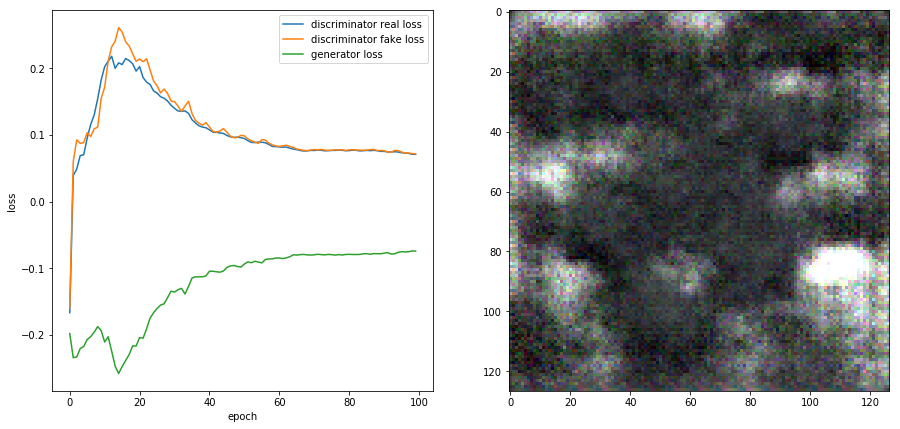

KeyboardInterrupt: 

In [35]:
generator = Generator(noise_DIM = noise_DIM)
discriminator = Discriminator()

if use_cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()

LAMBDA = 1e-2
num_epochs = 800
iterations_per_epoch = 1

#betas=(0.4, 0.999),
reg_coef = 1e-4
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-3, betas=(0.4, 0.999), weight_decay=reg_coef)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-3, betas=(0.4, 0.999), weight_decay=reg_coef)

k_d, k_g = 1, 4
C = .02
generator.train()
discriminator.train()

one = torch.ones([1])
mone = -1*one

if use_cuda:
    one = one.cuda()
    mone = mone.cuda()

noise_shape = (batch_size, noise_DIM, small_width//2**(n+2)-1, small_height//2**(n+2)-1)

grid_source = build_grid(big_repeated.size(2), small_height-1)

d_losses = []
g_losses = []
r_losses = []
f_losses = []
#fig = plt.figure(figsize = (10,10))
#plt.ion()
for epoch in range(num_epochs):
    d_loss = []
    g_loss = []
    r_loss = []
    f_loss = []
    for it in range(iterations_per_epoch):
    
        # Optimize D
        grid_shifted = random_crop_grid(big_repeated,grid_source)
        #Sample using grid sample
        discr_input = F.grid_sample(big_repeated, grid_shifted.double())
                
        if use_cuda:
            discr_input = discr_input.cuda()
        
        #print(type(discr_input))
        for i in range(k_d):
        
            d_optimizer.zero_grad()
            data_discr = discriminator(discr_input.float())
            real_loss = data_discr.mean()
            #real_loss.backward()
            
            # fake data
            noise = Variable(generate_noise(noise_shape).float())
            if use_cuda:
                noise = noise.cuda()
                
            data_gen = generator(noise)
            #print(data_gen.shape)
            data_gen_discr = discriminator(data_gen.float())
            fake_loss = data_gen_discr.mean()
            
            grad_penalty = calculate_gradient_penalty(discriminator, discr_input.float(), data_gen)*LAMBDA

            # total loss
            loss = - real_loss + fake_loss + grad_penalty*LAMBDA
            loss.backward(retain_graph=True)
            d_optimizer.step()
            
            for p in discriminator.parameters():
                p.data.clamp_(-C, C)
                    
            if use_cuda:
                f_loss.append(fake_loss.cpu().data.numpy().squeeze())
                r_loss.append(real_loss.cpu().data.numpy().squeeze())
                d_loss.append(loss.cpu().data.numpy().squeeze())
            else:
                f_loss.append(fake_loss.data.numpy().squeeze())
                r_loss.append(real_loss.data.numpy().squeeze())
                d_loss.append(loss.cpu().data.numpy().squeeze())
            
        # Optimize G
        for i in range(k_g):
            #noise = generate_noise(noise_shape).float()
            #if use_cuda:
            #    noise = noise.cuda()
            data_gen = generator(noise)
            loss = - discriminator(data_gen).mean()
            g_optimizer.zero_grad()
            loss.backward()
            g_optimizer.step()
            if use_cuda:
                g_loss.append(loss.cpu().data.numpy().squeeze())
            else:
                g_loss.append(loss.data.numpy().squeeze())
     
    clear_output(wait=True)
    #print('Epoch #{}, D loss {}'.format(epoch+1, loss.cpu().data.numpy().squeeze()))
    print('Epoch #{}, D loss {}'.format(epoch+1, sum(d_loss)/len(d_loss)))
    print('Epoch #{}, G loss {}'.format(epoch+1, sum(g_loss)/len(g_loss)))
    
    d_losses.append(sum(d_loss)/len(d_loss))
    g_losses.append(sum(g_loss)/len(g_loss))
    f_losses.append(sum(f_loss)/len(f_loss))
    r_losses.append(sum(r_loss)/len(r_loss))
    
    #fig.clf()
    #ax = plt.gca()
    plt.figure(figsize=(15,7))
    plt.subplot(121)
    plt.plot(r_losses, label = 'discriminator real loss')
    plt.plot(f_losses, label = 'discriminator fake loss')
    plt.plot(g_losses, label = 'generator loss')

    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    plt.subplot(122)
    res = data_gen[0].data.cpu().permute(1,2,0).numpy().squeeze()
    plt.imshow(np.clip(res, 0, 1))
    #plt.draw()
    plt.show()

    #plt.pause(0.0001)

In [39]:
torch.save(generator.state_dict(), 'gen_param_WGP.pkl')
torch.save(discriminator.state_dict(), 'discr_param_WGP.pkl')

In [46]:
noise = generate_noise((1, noise_DIM, 46, 46)).float()
if use_cuda:
    noise = noise.cuda()
data_gen = generator(noise)

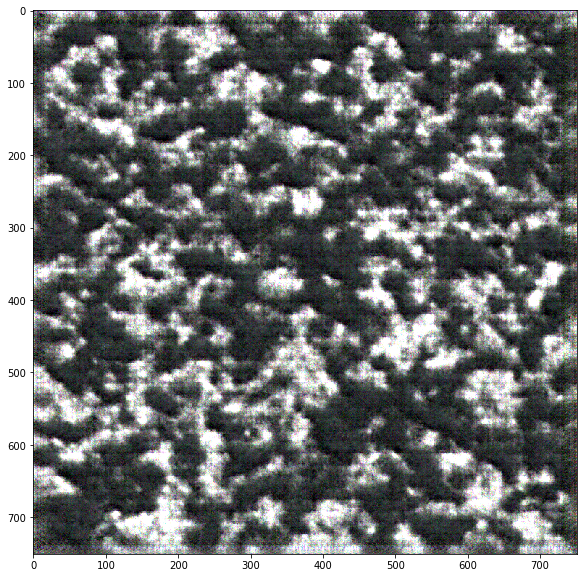

In [47]:
plt.figure(figsize=(10,10))
res = data_gen[0].data.cpu().permute(1,2,0).numpy().squeeze()
plt.imshow(np.clip(res, 0, 1))

Epoch #800, D loss 9.862439765129238e-05
Epoch #800, G loss -0.011635832255706191


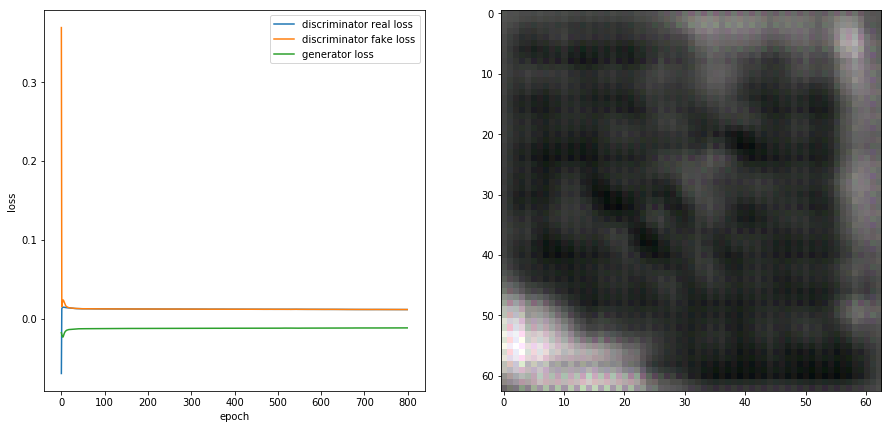

In [33]:
generator = Generator(noise_DIM = noise_DIM)
discriminator = Discriminator()

if use_cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()

LAMBDA = 1e-2
num_epochs = 800
iterations_per_epoch = 1

#betas=(0.4, 0.999),
reg_coef = 1e-4
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-3, betas=(0.4, 0.999), weight_decay=reg_coef)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-3, betas=(0.4, 0.999), weight_decay=reg_coef)

k_d, k_g = 1, 4
C = .03
generator.train()
discriminator.train()

one = torch.ones([1])
mone = -1*one

if use_cuda:
    one = one.cuda()
    mone = mone.cuda()

noise_shape = (batch_size, noise_DIM, small_width//2**(n+2)-1, small_height//2**(n+2)-1)

grid_source = build_grid(big_repeated.size(2), small_height-1)

d_losses = []
g_losses = []
r_losses = []
f_losses = []
#fig = plt.figure(figsize = (10,10))
#plt.ion()
for epoch in range(num_epochs):
    d_loss = []
    g_loss = []
    r_loss = []
    f_loss = []
    for it in range(iterations_per_epoch):
    
        # Optimize D
        grid_shifted = random_crop_grid(big_repeated,grid_source)
        #Sample using grid sample
        discr_input = F.grid_sample(big_repeated, grid_shifted.double())
                
        if use_cuda:
            discr_input = discr_input.cuda()
        
        #print(type(discr_input))
        for i in range(k_d):
        
            d_optimizer.zero_grad()
            data_discr = discriminator(discr_input.float())
            real_loss = data_discr.mean()
            #real_loss.backward()
            
            # fake data
            noise = Variable(generate_noise(noise_shape).float())
            if use_cuda:
                noise = noise.cuda()
                
            data_gen = generator(noise)
            #print(data_gen.shape)
            data_gen_discr = discriminator(data_gen.float())
            fake_loss = data_gen_discr.mean()
            
            grad_penalty = calculate_gradient_penalty(discriminator, discr_input.float(), data_gen)*LAMBDA

            # total loss
            loss = - real_loss + fake_loss + grad_penalty*LAMBDA
            loss.backward(retain_graph=True)
            d_optimizer.step()
            
            for p in discriminator.parameters():
                p.data.clamp_(-C, C)
                    
            if use_cuda:
                f_loss.append(fake_loss.cpu().data.numpy().squeeze())
                r_loss.append(real_loss.cpu().data.numpy().squeeze())
                d_loss.append(loss.cpu().data.numpy().squeeze())
            else:
                f_loss.append(fake_loss.data.numpy().squeeze())
                r_loss.append(real_loss.data.numpy().squeeze())
                d_loss.append(loss.cpu().data.numpy().squeeze())
            
        # Optimize G
        for i in range(k_g):
            #noise = generate_noise(noise_shape).float()
            #if use_cuda:
            #    noise = noise.cuda()
            data_gen = generator(noise)
            loss = - discriminator(data_gen).mean()
            g_optimizer.zero_grad()
            loss.backward()
            g_optimizer.step()
            if use_cuda:
                g_loss.append(loss.cpu().data.numpy().squeeze())
            else:
                g_loss.append(loss.data.numpy().squeeze())
     
    clear_output(wait=True)
    #print('Epoch #{}, D loss {}'.format(epoch+1, loss.cpu().data.numpy().squeeze()))
    print('Epoch #{}, D loss {}'.format(epoch+1, sum(d_loss)/len(d_loss)))
    print('Epoch #{}, G loss {}'.format(epoch+1, sum(g_loss)/len(g_loss)))
    
    d_losses.append(sum(d_loss)/len(d_loss))
    g_losses.append(sum(g_loss)/len(g_loss))
    f_losses.append(sum(f_loss)/len(f_loss))
    r_losses.append(sum(r_loss)/len(r_loss))
    
    #fig.clf()
    #ax = plt.gca()
    plt.figure(figsize=(15,7))
    plt.subplot(121)
    plt.plot(r_losses, label = 'discriminator real loss')
    plt.plot(f_losses, label = 'discriminator fake loss')
    plt.plot(g_losses, label = 'generator loss')

    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    plt.subplot(122)
    res = data_gen[0].data.cpu().permute(1,2,0).numpy().squeeze()
    plt.imshow(np.clip(res, 0, 1))
    #plt.draw()
    plt.show()

    #plt.pause(0.0001)

In [ ]:
noise = generate_noise((1, noise_DIM, 128-1, 128-1)).float()
if use_cuda:
    noise = noise.cuda()
data_gen = generator(noise)

plt.figure(figsize=(10,10))
res = data_gen[0].data.cpu().permute(1,2,0).numpy().squeeze()
plt.imshow(np.clip(res, 0, 1))

Epoch #800, D loss 0.00017790307174436748
Epoch #800, G loss -0.5565086007118225


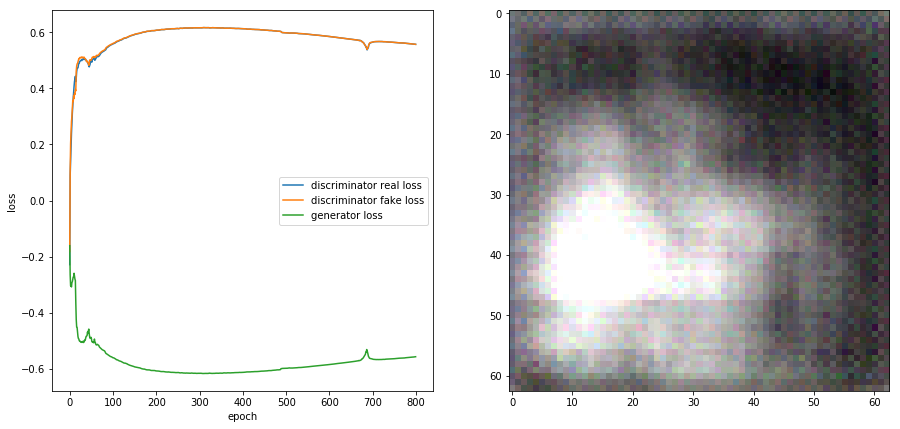

In [35]:
generator = Generator(noise_DIM = noise_DIM)
discriminator = Discriminator()

if use_cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()

LAMBDA = 1e-2  # 10 говорят хорошо работает - можно попробовать
num_epochs = 800
iterations_per_epoch = 1

#betas=(0.4, 0.999),
reg_coef = 1e-4
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-3, betas=(0.4, 0.999), weight_decay=reg_coef)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-3, betas=(0.4, 0.999), weight_decay=reg_coef)

k_d, k_g = 1, 4
C = .03
generator.train()
discriminator.train()

one = torch.ones([1])
mone = -1*one

if use_cuda:
    one = one.cuda()
    mone = mone.cuda()

noise_shape = (batch_size, noise_DIM, small_width//2**(n+2)-1, small_height//2**(n+2)-1)

grid_source = build_grid(big_repeated.size(2), small_height-1)

d_losses = []
g_losses = []
r_losses = []
f_losses = []
#fig = plt.figure(figsize = (10,10))
#plt.ion()
for epoch in range(num_epochs):
    d_loss = []
    g_loss = []
    r_loss = []
    f_loss = []
    for it in range(iterations_per_epoch):
    
        # Optimize D
        grid_shifted = random_crop_grid(big_repeated,grid_source)
        #Sample using grid sample
        discr_input = F.grid_sample(big_repeated, grid_shifted.double())
                
        if use_cuda:
            discr_input = discr_input.cuda()
        
        #print(type(discr_input))
        for i in range(k_d):
        
            d_optimizer.zero_grad()
            data_discr = discriminator(discr_input.float())
            real_loss = data_discr.mean()
            #real_loss.backward()
            
            # fake data
            noise = Variable(generate_noise(noise_shape).float())
            if use_cuda:
                noise = noise.cuda()
                
            data_gen = generator(noise)
            #print(data_gen.shape)
            data_gen_discr = discriminator(data_gen.float())
            fake_loss = data_gen_discr.mean()
            
            grad_penalty = calculate_gradient_penalty(discriminator, discr_input.float(), data_gen)*LAMBDA

            # total loss
            loss = - real_loss + fake_loss + grad_penalty*LAMBDA
            loss.backward(retain_graph=True)
            d_optimizer.step()
            
            for p in discriminator.parameters():
                p.data.clamp_(-C, C)
                    
            if use_cuda:
                f_loss.append(fake_loss.cpu().data.numpy().squeeze())
                r_loss.append(real_loss.cpu().data.numpy().squeeze())
                d_loss.append(loss.cpu().data.numpy().squeeze())
            else:
                f_loss.append(fake_loss.data.numpy().squeeze())
                r_loss.append(real_loss.data.numpy().squeeze())
                d_loss.append(loss.cpu().data.numpy().squeeze())
            
        # Optimize G
        for i in range(k_g):
            #noise = generate_noise(noise_shape).float()
            #if use_cuda:
            #    noise = noise.cuda()
            data_gen = generator(noise)
            loss = - discriminator(data_gen).mean()
            g_optimizer.zero_grad()
            loss.backward()
            g_optimizer.step()
            if use_cuda:
                g_loss.append(loss.cpu().data.numpy().squeeze())
            else:
                g_loss.append(loss.data.numpy().squeeze())
     
    clear_output(wait=True)
    #print('Epoch #{}, D loss {}'.format(epoch+1, loss.cpu().data.numpy().squeeze()))
    print('Epoch #{}, D loss {}'.format(epoch+1, sum(d_loss)/len(d_loss)))
    print('Epoch #{}, G loss {}'.format(epoch+1, sum(g_loss)/len(g_loss)))
    
    d_losses.append(sum(d_loss)/len(d_loss))
    g_losses.append(sum(g_loss)/len(g_loss))
    f_losses.append(sum(f_loss)/len(f_loss))
    r_losses.append(sum(r_loss)/len(r_loss))
    
    #fig.clf()
    #ax = plt.gca()
    plt.figure(figsize=(15,7))
    plt.subplot(121)
    plt.plot(r_losses, label = 'discriminator real loss')
    plt.plot(f_losses, label = 'discriminator fake loss')
    plt.plot(g_losses, label = 'generator loss')

    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    plt.subplot(122)
    res = data_gen[0].data.cpu().permute(1,2,0).numpy().squeeze()
    plt.imshow(np.clip(res, 0, 1))
    #plt.draw()
    plt.show()

    #plt.pause(0.0001)